# Tutorial Five: Multicollinearity

## 实验前的准备

本次实验我们载入一些Python的安装包，如下：

In [10]:
from sklearn.datasets import load_diabetes

import os

import pandas as pd
import numpy as np
import random
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import math

from sklearn import preprocessing # Data Preprocessing
import statsmodels.api as sm # LSE, Ridge Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 
from statsmodels.multivariate.pca import PCA # PCR

from jupyterquiz import display_quiz 

本次实验中，所使用的数据集是

In [11]:
Data = pd.read_csv("./Project/Data/Data_4.csv")
print(Data.head())

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    315    81      7    24   38     39     14    3449    835      69    321   
1    479   130     18    66   72     76      3    1624    457      63    224   
2    496   141     20    65   78     37     11    5628   1575     225    828   
3    321    87     10    39   42     30      2     396    101      12     48   
4    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks  PutOuts  Assists  Errors  Salary  
0   414     375      632       43      10   475.0  
1   266     263      880       82      14   480.0  
2   838     354      200       11       3   500.0  
3    46      33      805       40       4    91.5  
4   336     194      282      421      25   750.0  


我们可以简单统计一下这个数据集中的一些基本信息，如样本量、特征维度，即

In [12]:
p = Data.shape[1]-1
n = Data.shape[0]

print("The number of features is",p)
print("The sample size is",n)

The number of features is 16
The sample size is 263


## 背景

本次数据来自于1986年至1987年间美国职业棒球大联盟。这个数据记录了263名大联盟的选手所采集的收入数据及其历史棒球运动的表现。

## 数据
在本次数据中，共有17个变量（1个响应变量与16个自变量），具体如下表所示：
<table width = c(100,800,700), center = True>
    <tr>
        <td> 变量名                  </td>
        <td> 英文变量含义                 </td>
        <td> 中文变量含义                 </td>
    </tr>
    <tr>
        <td> AtBat                          </td>
        <td> Number of times at bat in 1986 </td>
        <td> 1986年间轮到击球的次数            </td>
    </tr>
    <tr>
        <td> Hits                         </td>
        <td> Number of hits in 1986       </td>
        <td> 1986年间击中球的次数           </td>
    </tr>
    <tr>
        <td> HmRun                         </td>
        <td> Number of home runs in 1986   </td>
        <td> 1986年间全垒打的次数             </td>
    </tr>
     <tr>
        <td> Runs                              </td>
        <td> Number of runs in 1986            </td>
        <td> 1986年间得分的次数                   </td>
    </tr>
    <tr>
        <td> RBI                               </td>
        <td> Number of runs batted in in 1986  </td>
        <td> 1986年间打者打点的次数                   </td>
    </tr>
    <tr>
        <td> Walks                               </td>
        <td> Number of walks in 1986  </td>
        <td> 1986年间打击手被保送的次数                   </td>
    </tr>
    <tr>
        <td> Years                               </td>
        <td> Number of years in the major leagues  </td>
        <td> 在大联盟的年限                  </td>
    </tr>
     <tr>
        <td> CAtBat                               </td>
        <td> Number of times at bat during his career  </td>
        <td> 在其棒球职业生涯中轮到击球的次数                 </td>
    </tr>
    <tr>
        <td> CHits                              </td>
        <td> Number of hits during his career  </td>
        <td> 在其棒球职业生涯中击中球的次数                 </td>
    </tr>
    <tr>
        <td> CHmRun                              </td>
        <td> Number of home runs during his career  </td>
        <td> 在其棒球职业生涯中全垒打的次数                 </td>
    </tr>
    <tr>
        <td> CRuns                              </td>
        <td> Number of runs during his career  </td>
        <td> 在其棒球职业生涯中得分的次数                 </td>
    </tr>
    <tr>
        <td> CRBI                              </td>
        <td> Number of runs batted in during his career  </td>
        <td> 在其棒球职业生涯中打者打点的次数                 </td>
    </tr>
    <tr>
        <td> CWalks                              </td>
        <td> Number of walks during his career  </td>
        <td> 在其棒球职业生涯中打击手被保送的次数                 </td>
    </tr>
    <tr>
        <td> PutOuts                              </td>
        <td> Number of put outs in 1986  </td>
        <td> 在1986年间接杀的次数                 </td>
    </tr>
    <tr>
        <td> Assists                             </td>
        <td> Number of assists in 1986  </td>
        <td> 在1986年间助杀的次数                 </td>
    </tr>
    <tr>
        <td> Errors                            </td>
        <td> Number of errors in 1986          </td>
        <td> 在1986年间失误的次数                 </td>
    </tr>
    <tr>
        <td> Salary                            </td>
        <td> 1987 annual salary on opening day in thousands of dollars          </td>
        <td> 在1987年开业时年薪（单位：千美元）         </td>
    </tr>
</table>

我们想了解棒球运动员的收入与其运动表现的关系。因此，Salary是本次模型中的标签（或响应变量），其余16个变量为特征（或自变量）。这个数据集中涉及棒球比赛中的专有名词，同学们可以课后参考视频[1]。

## 任务

本次实验中，我们需要解决以下问题：

1. 如何判断特征数据中是否存在多重共线性？
2. 如何构建岭回归模型？
3. 如何构建主成分回归模型？
4. 从预测的角度而言，普通线性回归模型、岭回归模型以及主成分回归模型，哪个模型更优？

## 解决方案

### Task 0：数据预处理

在评价模型时，倘若我们采用同一个数据集进行构建模型与评价模型，往往会造成**过拟合**的情形。为避免这个问题，我们会提前将数据集拆分为两个部分，一部分数据被称为训练集，用于模型训练。另一个部分为测试集，用于评价模型。

留出法是划分数据集的一种常见方法。在本次实验中，我们保留80%的数据用于训练模型，而20%的数据用于评价模型。在划分训练集和测试集时，我们采用随机采样。

In [13]:
n_train = 210 # 80% instances used for training
n_test = n-n_train
seed = 1
random.seed(seed)
index = range(0,n)
index_selected = random.sample(index,n_train)
index_selected.sort()

Data_train = Data.loc[index_selected]
Data_test = Data.drop(index = index_selected)

用于建模的数据集为

In [14]:
Data_train.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
0,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
1,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
2,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
3,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5
4,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0


用于评价的数据集为

In [15]:
Data_test.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
12,239,60,0,30,11,22,6,1941,510,4,309,103,207,121,151,6,700.0
15,190,46,2,24,8,15,5,479,102,5,65,23,39,102,177,16,175.0
17,413,92,16,72,48,65,1,413,92,16,72,48,65,280,9,5,100.0
18,426,109,3,55,43,62,1,426,109,3,55,43,62,361,22,2,115.0
19,472,116,16,60,62,74,6,1924,489,67,242,251,240,518,55,3,600.0


除了划分训练集和测试集之外，我们还需要将数据进行预处理。在本次实验中，我们将特征，即自变量，进行**标准化**，而将标签，即响应变量，进行中心化。

In [16]:
## Pre-processing
X_train = Data_train.drop(columns = ['Salary'],axis = 1)
Y_train = Data_train.Salary
X_test = Data_test.drop(columns = ["Salary"],axis=1)
Y_test = Data_test.Salary

X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True)/np.sqrt(n_train)
Y_train_centered = preprocessing.scale(Y_train, with_mean = True, with_std=False)
Y_train_mean = np.average(Y_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True)/np.sqrt(n_test)


我们可以建立一个线性回归模型，即

In [17]:
X_train_withintercept = sm.add_constant(X_train)
model = sm.OLS(Y_train,X_train_withintercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     17.42
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           1.88e-29
Time:                        19:29:48   Log-Likelihood:                -1483.7
No. Observations:                 210   AIC:                             3001.
Df Residuals:                     193   BIC:                             3058.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.2230     91.411      2.015      0.045       3.930     364.515
AtBat         -2.5127      0.673     -3.732      0.000      -3.841      -1.185
Hits          10.9852      2.545      4.317      0.000       5.967      16.004
HmRun         -4.3432      6.662     -0.652      0.515     -17.483       8.796
Runs          -5.0320      3.085     -1.631      0.104     -11.116       1.052
RBI           -1.4118      2.666     -0.530      0.597      -6.670       3.846
Walks          7.8608      1.929      4.075      0.000       4.056      11.665
Years        -10.2313     13.991     -0.731      0.465     -37.826      17.364
CAtBat        -0.0192      0.141     -0.136      0.892      -0.298       0.259
CHits         -0.1728      0.688     -0.251      0.802      -1.530       1.184
CHmRun         3.0831      1.862      1.656      0.099      -0.589       6.755
CRuns          1.1291      0.781      1.445      0.150      -0.412       2.670
CRBI           0.1071      0.766      0.140      0.889      -1.404       1.618
CWalks        -0.7261      0.349     -2.081      0.039      -1.414      -0.038
PutOuts        0.1723      0.082      2.098      0.037       0.010       0.334
Assists        0.4055      0.225      1.803      0.073      -0.038       0.849
Errors        -4.4775      4.427     -1.011      0.313     -13.208       4.253
==============================================================================
Omnibus:                      113.886   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              966.375
Skew:                           1.909   Prob(JB):                    1.43e-210
Kurtosis:                      12.791   Cond. No.                     1.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

在上述结论中，我们发现：
1. 有一些特征前的回归系数与专业认知不一致；比如：HmRun。
2. 在第二个注意中，Python也表明需要注意多重共线性的问题。

### Task 1:  如何判断特征数据中是否存在多重共线性？

多重共线性是严重影响线性回归模型效果的原因之一。倘若数据中存在多重共线性，自变量之间存在接近线性的相关性。虽然多重共线性并不违反线性回归模型的基本假设，但是多重共线性会影响最小二乘估计的效果。

一方面，我们可以先关注一下特征之间自身的相关性，并绘制热力图。

<AxesSubplot:>

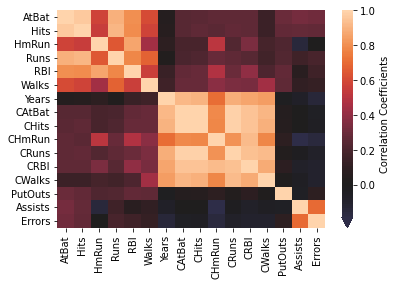

In [18]:
pcorr = X_train.corr(method = 'pearson')
tick_ = (np.arange(0,13,2)-2)/10
dict_ = {"orientation":'vertical',
         'label':'Correlation Coefficients',
         "drawedges":False,
         "ticklocation":"top",
         "extend":"min",
        "filled":True,
         "alpha":0.8,
         "cmap":"cmap",
         "ticks":tick_}
sns.heatmap(pcorr,cbar_kws= dict_,center=0)

从上图中可以发现，颜色越浅的特征之间相关性越强，而颜色越深的特征之间相关性越弱。很容易发现AtBat与Hits，CAtBat与CHits，Assists与Errors都有比较强的相关性。从相关阵可以初步判断出数据之间可能出现**多重共线性**。

另一方面，在实际中，我们通常根据方差扩大因子和特征值两类指标来判断数据是否存在多重共线性。

#### 方差扩大因子法

方差扩大因子法中，一般我们需要设置一个临界值，在本次实验中我们设定为5。

In [19]:
vif_cv = 5 # The criterion value of VIF

方差扩大因子的计算方法：
假定特征数据已经经过标准化，现数据有
$$
X = \begin{pmatrix}
x_{11} & x_{12} & \cdots & x_{1p}\\
x_{21} & x_{22} & \cdots & x_{2p}\\
\vdots & \vdots &  & \vdots \\
x_{n1} & x_{n2} & \cdots & x_{np}\\
\end{pmatrix}
$$

方差扩大因子指的是$(X'X)^{-1}$的对角线元素。

1. 根据方差扩大因子的定义，我们可以通过矩阵计算来确定方差扩大因子，如方法一。

In [20]:
# Method One
C = np.linalg.inv(np.dot(X_train_standardized.T,X_train_standardized))
VIF_1 = np.diag(C)
print("The VIF's are", np.round(VIF_1,2))

The VIF's are [ 22.91  30.81   8.11  14.14  11.67   3.92   9.59 242.45 474.68  45.5
 154.87 133.93  17.44   1.28   2.65   2.13]


2. 在Python中statsmodel包中自带函数variance_inflation_factor也可以直接用于计算方差扩大因子，如方法二。

In [21]:
# Method Two
VIF_2 = [variance_inflation_factor(X_train_standardized[:,0:p], i) for i in range(p)]
print("The VIF's are", np.round(VIF_2,2))

The VIF's are [ 22.91  30.81   8.11  14.14  11.67   3.92   9.59 242.45 474.68  45.5
 154.87 133.93  17.44   1.28   2.65   2.13]


方差扩大因子的命名来源是基于方法一。但是，问题是：为什么方差扩大因子能够度量特征存在多重共线性？

举例来说，以$x_j$作为响应变量，其他特征$x_1,x_2,\cdots,x_{j-1},x_{j+1},\cdots,x_{p}$作为自变量，构建线性回归模型即
$$
x_j = \alpha_0 + \alpha_1 x_1 + \alpha_2 x_2 + \cdots +\alpha_{j-1}x_{j-1} + \alpha_{j+1}x_{j+1} + \cdots + \alpha_p x_p +\epsilon
$$

如果这个特征能够被其他特征近似看作其他特征的线性组合，那么我们称这个现象为**多重共线性**。基于这个想法，如果上述回归模型的决定系数$R^2$很接近于1，那么这个特征很有可能看作其他特征的线性组合。因此，多重共线性VIF还有一种计算方法，即
$$
\text{VIF}_j = \frac{1}{1-R_j^2} 
$$

In [22]:
# Method Three
X_1 = X_train_standardized[:,0]
X_others = X_train_standardized[:,1:p]
model_vif = sm.OLS(X_1,X_others).fit()
X_1_VIF = 1/(1-model_vif.rsquared)
print("The VIF of the first feature is", np.round(X_1_VIF,2))

The VIF of the first feature is 22.91


方差扩大因子的评价方式：如果方差扩大因子越大，那么可以认为多重共线性是严重的。

可以发现，在计算有些指标的时候，需要调用Python中线性回归模型的结果。我们这里补充一些线性回归模型中常见需要调用的函数，具体如下：

In [23]:
### 补充内容：
model_vif.summary()
## 建模类
model_vif.params # 回归系数(向量，p)
model_vif.bse # 回归系数的标准误
model_vif.tvalues # 回归系数的t统计量（向量，p）
model_vif.pvalues # 回归系数的t检验对应的p值（向量，p）
model_vif.fittedvalues # 回归模型的拟合值（向量，n）
model_vif.resid # 回归模型的残差（向量，n）

## 评价类
model_vif.fvalue # 回归模型的F检验统计量
model_vif.f_pvalue # 回归模型的F检验对应的p值
model_vif.rsquared # 回归模型的决定系数R2
model_vif.rsquared_adj # 回归模型修正后的决定系数 Adj. R2
model_vif.ess # 回归平方和
model_vif.ssr # 残差平方和
model_vif.aic # AIC
model_vif.bic # BIC

-1104.3653729107148

#### 特征值方法

我们可以计算$\mathbf{X}'\mathbf{X}$的特征值来判断数据多重共线性的程度。

In [24]:
R = np.dot(X_train_standardized.T,X_train_standardized)
W, V = np.linalg.eig(R)
W = -1* np.sort(-1*W)
W_diag = np.diag(W)
V = V.T
print("The eigen values are", np.round(W,4))

The eigen values are [7.2985e+00 3.9851e+00 1.7352e+00 9.1210e-01 6.8070e-01 5.5120e-01
 2.6490e-01 1.8050e-01 1.2800e-01 1.0050e-01 6.0000e-02 5.3300e-02
 2.8200e-02 1.6100e-02 4.4000e-03 1.3000e-03]


这里特别需要说明一下，np.linalg.eig函数所输出特征值并不是按从大到小的顺序进行排列的。

基于所计算的特征值，我们进一步需要计算条件数。

In [25]:
Condition_Number = np.sqrt(np.max(W)/np.min(W))
print("The condition number is",np.round(Condition_Number,4))

The condition number is 75.7146


可以发现：所计算出的条件数也是比较大的。这里也可以预先设置临界值进行判断。

同时，我们也可以重新运行线性回归模型，查看所计算的条件数。

In [26]:
model_ols = sm.OLS(Y_train_centered,X_train_standardized).fit()
print("The condition number is",round(model_ols.condition_number,4))

The condition number is 75.7146


### Task 2：如何构建岭回归模型？

岭回归估计为
$$
\hat{\mathbf{\beta}}(k) = (\mathbf{X}'\mathbf{X} + k \mathbf{I})^{-1} \mathbf{X}' \mathbf{y}.
$$

在Python的statmodels.api包中OLS.fit_regularized可以实现，具体如下：

In [27]:
## Ridge Regression
alpha  = 0.1 # A hyperparameter in Ridge Regression (equivalently but not equally, k in slides)
model_rr = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
print("The parameters in the ridge regression are ",np.round(model_rr.params,2))

The parameters in the ridge regression are  [ 84.07  97.4   62.58  87.16  87.79 113.32 100.7  128.48 132.56 146.93
 137.78 145.26 124.65  51.17   7.34  -7.15]


在上述代码中，有一个超参数$\alpha$，与我们在介绍岭回归中的$k$并不是同一个参数，但是与$k$是等价的。这是因为这个函数本身是为了解决Elastic Net问题。在Elastic Net中，最优化问题是
$$
0.5* RSS/n +\alpha *((1-L1_{wt})*|\mathbf{\beta}|_2^2/2 + L1_{wt} * |\mathbf{\beta}|_1)
$$
其中，
- RSS：原本的偏差平方和；
- n：样本量；
- $|\cdot|_1,|\cdot|_2$：$L_1$和$L_2$范数。

In [28]:
display_quiz("./Question/T5_Q1.json")

<IPython.core.display.Javascript object>

</details>

<details><summary>Q1【点击提示】</summary>
    
   请运行一下code来进行验证。
<code>
k = alpha * n_train # The relation between alpha and k
print("The parameters in the ridge regression are ", np.around(np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ Y_train_centered,2))
</code>
</details>

In [29]:
alpha_num = 100
alpha_vec = np.array(list(range(0,alpha_num)))/alpha_num/1000
RR_coef = []
RR_vif = []

for alpha in alpha_vec:
    rr_model = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
    rr_coef = rr_model.params
    RR_coef.append(rr_coef)

如何确定最优的超参数？这是岭回归模型中一个重要的问题。

我们可以绘制岭迹图，具体如下：

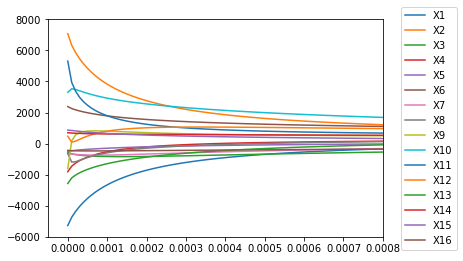

In [30]:
for i in range(p):
    plt.plot(alpha_vec, np.array(RR_coef)[:,i],label = "X%d"%(i+1))

plt.axis([-0.00005,0.0008,-6000,8000])    
plt.legend(loc="right",bbox_to_anchor=(1.25,0.5),borderaxespad=1)

同时，我们可以通过计算不同k（alpha）下的VIF值，当VIF符合临界值条件，且为最小的k（alpha），就是我们所选择的超参数。

In [31]:
C_k = []
for alpha in alpha_vec:
    k = alpha * n_train
    c_k = np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ X_train_standardized @ np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p))
    C_k.append(np.mean(np.diag(c_k)))

alpha_best = alpha_vec[np.min(np.where(np.array(C_k) < vif_cv))]
print("The chosen value of alpha is", alpha_best)

The chosen value of alpha is 0.0001


我们重新构建了在最优的k（或者alpha）时的岭回归估计，如下：

In [25]:
model_rr_best = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha_best)
model_rr_best_coef = model_rr_best.params

这里我们得到的估计，记为$\hat{\mathbf{\beta}}^{\text{rr}}$

### Task 3：如何构建主成分回归模型？

在PCR模型中，第一步需要构建特征的主成分。

In [27]:
model_pca = PCA(X_train_standardized,standardize = False, demean = True)
model_pca_cr = model_pca.eigenvals # contribution rate of each component
print("The percentages of total variance are", np.around(model_pca_cr,4))

The percentages of total variance are [7.2985e+00 3.9851e+00 1.7352e+00 9.1210e-01 6.8070e-01 5.5120e-01
 2.6490e-01 1.8050e-01 1.2800e-01 1.0050e-01 6.0000e-02 5.3300e-02
 2.8200e-02 1.6100e-02 4.4000e-03 1.3000e-03]


以上计算的就是$\mathbf{X}'\mathbf{X}$的特征值，也被称为每个主成分的贡献率。通过以下代码可以进行验证。

In [28]:
Corr_Mat = X_train_standardized.T @ X_train_standardized
Lambda, V = np.linalg.eig(Corr_Mat)
Lambda = sorted(Lambda,reverse = True)
print("The eigen values of X'X are ", np.around(Lambda,4))


The eigen values of X'X are  [7.2985e+00 3.9851e+00 1.7352e+00 9.1210e-01 6.8070e-01 5.5120e-01
 2.6490e-01 1.8050e-01 1.2800e-01 1.0050e-01 6.0000e-02 5.3300e-02
 2.8200e-02 1.6100e-02 4.4000e-03 1.3000e-03]


和岭回归模型中的超参数k（或alpha）一样，主成分分析中主成分个数也是一个超参数。如何选择主成分的个数也是一个重要的问题。

在主成分分析中，我们可以绘制scree plot来作出主成分个数的主观判断。

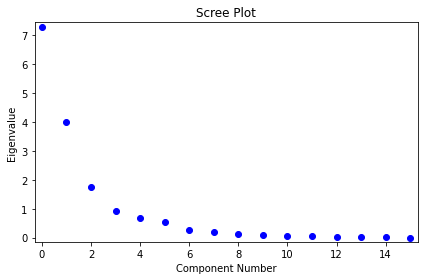

In [29]:
fig = model_pca.plot_scree(log_scale = False)

除此之外，我们还可以计算每增加一个主成分后，对信息**增量**是多少？我们可以计算累积贡献率。

The cummulative percentages of total variance are [0.4562 0.7052 0.8137 0.8707 0.9132 0.9477 0.9642 0.9755 0.9835 0.9898
 0.9935 0.9969 0.9986 0.9996 0.9999 1.    ]


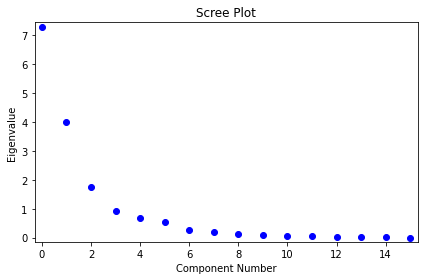

In [30]:
model_pca_ccr = np.cumsum(model_pca_cr)/p # cummulative contribution rate
print("The cummulative percentages of total variance are", np.around(model_pca_ccr,4))

fig = model_pca.plot_scree(log_scale = False)

我们选取主成分时需要其累积贡献率达到85%，即

In [31]:
pca_cv = 0.90

In [32]:
num_pca = np.min(np.where(model_pca_ccr > pca_cv))
print("The appropriate number of component is", (num_pca+1))


The appropriate number of component is 5


在确定主成分个数后，我们构建**新**特征（即主成分）代替原始特征，并拟合回归模型后。在通过线性变换，来估计主成分回归中的参数。

In [33]:
model_pca_selected = PCA(X_train_standardized,  standardize = False,  demean = True)
V = model_pca_selected.loadings
Z_train_standardized= X_train_standardized @ V[:,0:(num_pca+1)]
model_pcr = sm.OLS(Y_train_centered, Z_train_standardized).fit()
model_pcr_coef = V.T @ np.pad(model_pcr.params,(0,p-(num_pca+1)))


这里我们得到的估计，记为$\hat{\mathbf{\beta}}^{\text{prc}}$

### Task 4：比较三个模型预测结果

由于这个问题是一个回归问题，我们采用RMSE来作为衡量指标，即
$$
RMSE = \sqrt{n^{-1}\sum_{i=1}^n (\hat{y}_i - y_i)^2}
$$

第一，我们先构建线性回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，线性回归模型的预测结果为
$$
y_i^{\text{ols}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{ols}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{ols}}$采用最小二乘估计；

In [32]:
model_ols_coef = model_ols.params 
Y_pred_ols = Y_train_mean + X_test_standardized @ model_ols_coef
ols_rmse = np.sqrt(np.mean((Y_pred_ols-Y_test)**2))
print("The RMSE in the ordinary regression is", round(ols_rmse,4))

The RMSE in the ordinary regression is 591.1203


第二，我们再构建岭回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，岭回归模型的预测结果为
$$
y_i^{\text{rr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{rr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{rr}}$采用岭回归估计；


In [35]:
Y_pred_rr = Y_train_mean + X_test_standardized @ model_rr_best_coef
rr_rmse = np.sqrt(np.mean((Y_pred_rr-Y_test)**2))

print("The RMSE in the ridge regression is", round(rr_rmse,4))
    

The RMSE in the ridge regression is 566.0067


第三，我们最后构建主成分回归模型。对于每一个数据$(\mathbf{x}_i,y_i)$，主成分回归模型的预测结果为
$$
y_i^{\text{pcr}} = \hat{\beta}_0 + \mathbf{x}_i \hat{\mathbf{\beta}}^{\text{pcr}}
$$
这里
- $\hat{\beta}_0$采用训练集中响应变量的样本均值来估计；
- $\hat{\mathbf{\beta}}^{\text{pcrr}}$采用主成分回归估计；


In [36]:
Y_pred_pcr = Y_train_mean + X_test_standardized @ model_pcr_coef
pcr_rmse = np.sqrt(np.mean((Y_pred_pcr-Y_test)**2))

print("The RMSE in the ordinary regression is", round(pcr_rmse,4))

The RMSE in the ordinary regression is 566.4681


从预测的角度来看，岭回归模型和主成分回归模型均优于普通线性回归模型。

## Reference
[1] 棒球规则速成！从棒球小白到棒球通你只需要点开这个视频【棒球101合集】网址：https://www.bilibili.com/video/BV1Fa411P7P7/?spm_id_from=333.337.search-card.all.click&vd_source=1c65b0c7684a3149a7392f98602a49b4

[2] Izenman A J. Modern multivariate statistical techniques[J]. Regression, classification and manifold learning, 2008, 10: 978-0.

[3] Zou H, Hastie T. Regularization and variable selection via the elastic net[J]. Journal of the royal statistical society: series B (statistical methodology), 2005, 67(2): 301-320.